## Load Dataset from Kaggle

In [1]:
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xiaoyuchen007","key":"c639ec67428f56f7a3a2ba1c1a99ef43"}'}

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [00:50<00:00, 21.8MB/s]
100% 1.04G/1.04G [00:50<00:00, 22.0MB/s]


In [4]:
!unzip flickr8k.zip -d flickr_image

Streaming output truncated to the last 5000 lines.
  inflating: flickr_image/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr_image/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr_image/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr_image/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr_image/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr_image/Images/2846037553_1a1de50709.jpg  
  inflating: flickr_image/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr_image/Images/2846843520_b0e6211478.jpg  
  inflating: flickr_image/Images/2847514745_9a35493023.jpg  
  inflating: flickr_image/Images/2847615962_c330bded6e.jpg  
  inflating: flickr_image/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr_image/Images/2848266893_9693c66275.jpg  
  inflating: flickr_image/Images/2848571082_26454cb981.jpg  
  inflating: flickr_image/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr_image/Images/2848977044_446a31d86e.jpg  
  inflating: flickr_image/Images/2

Data Loader

In [5]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import pandas as pd
data = pd.read_csv("/content/flickr_image/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [7]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/flickr_image/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

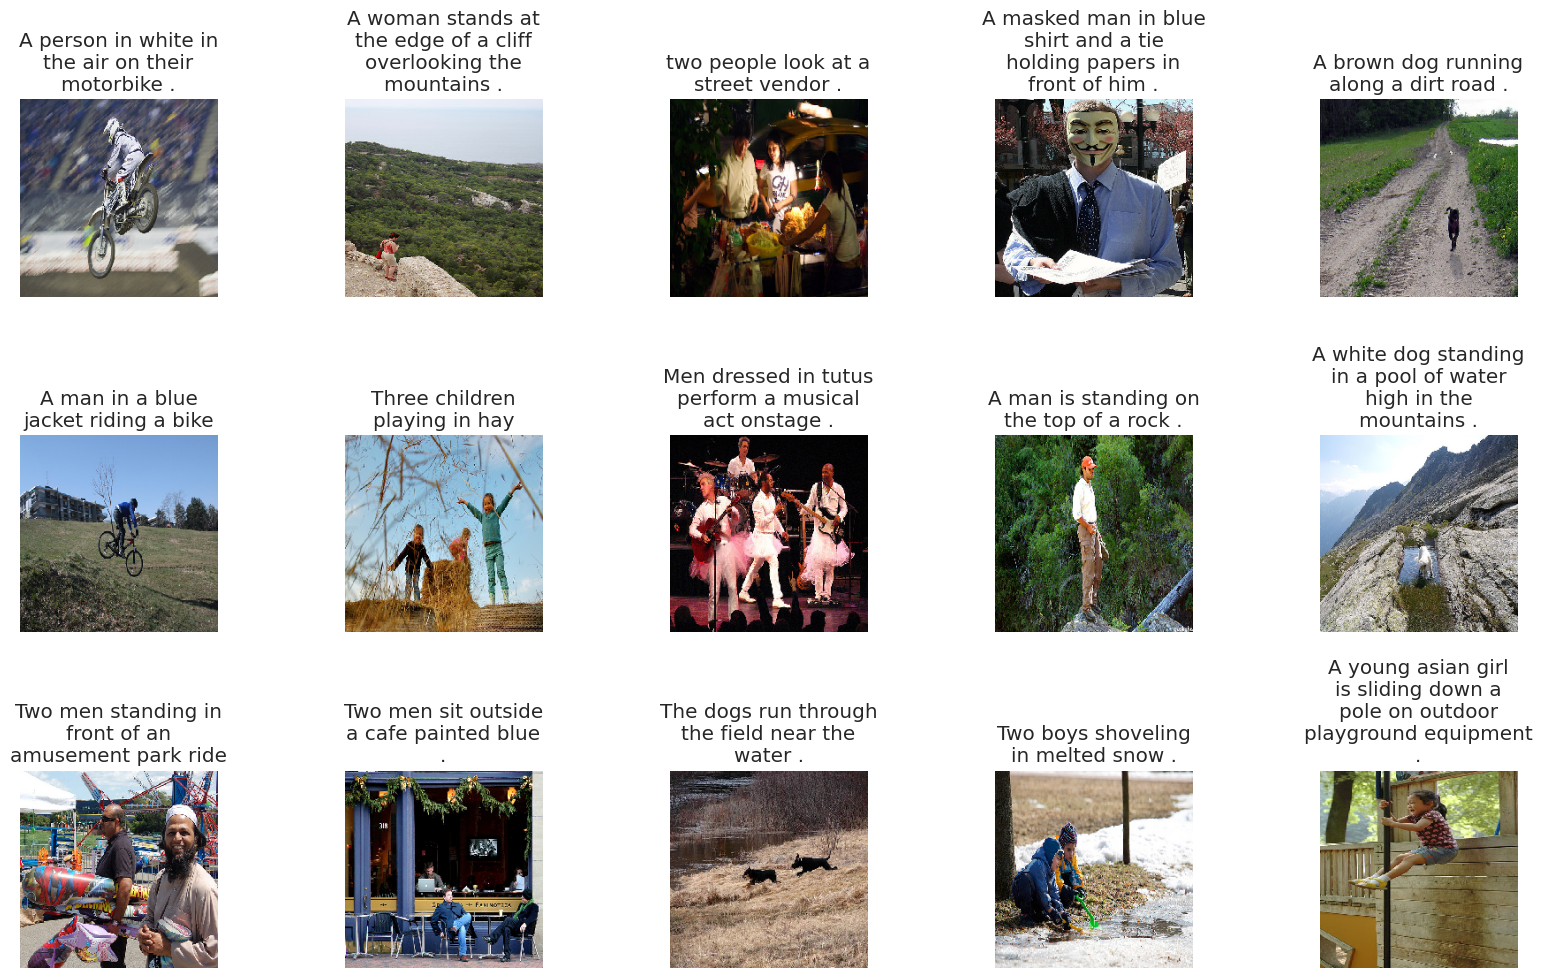

In [ ]:
display_images(data.sample(15))

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]
# train[0.7 train, 0.15 val], test[0.15 test]
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [ ]:
image_path = '/content/flickr_image/Images'

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img) 
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

In [ ]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
      return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
from tensorflow.keras.utils import plot_model

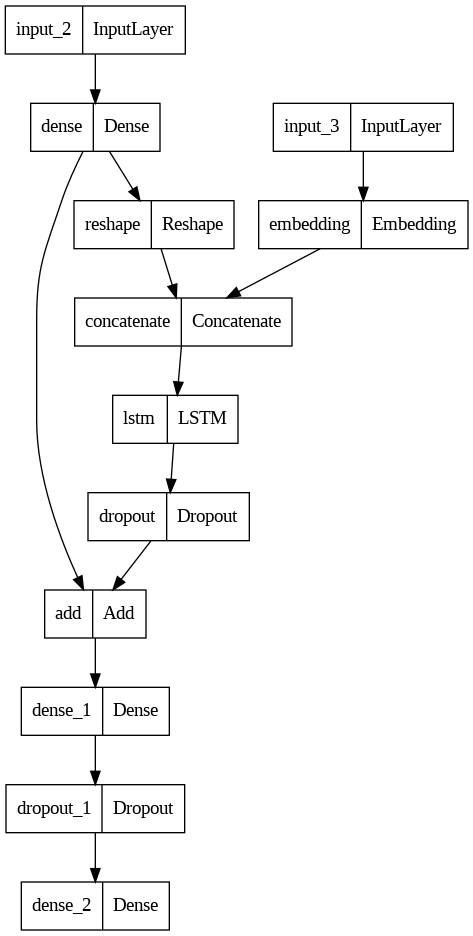

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    validation_split=0.2,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

In [ ]:
import torch
torch.save(caption_model, '/content/my_model.h5')

NameError: ignored

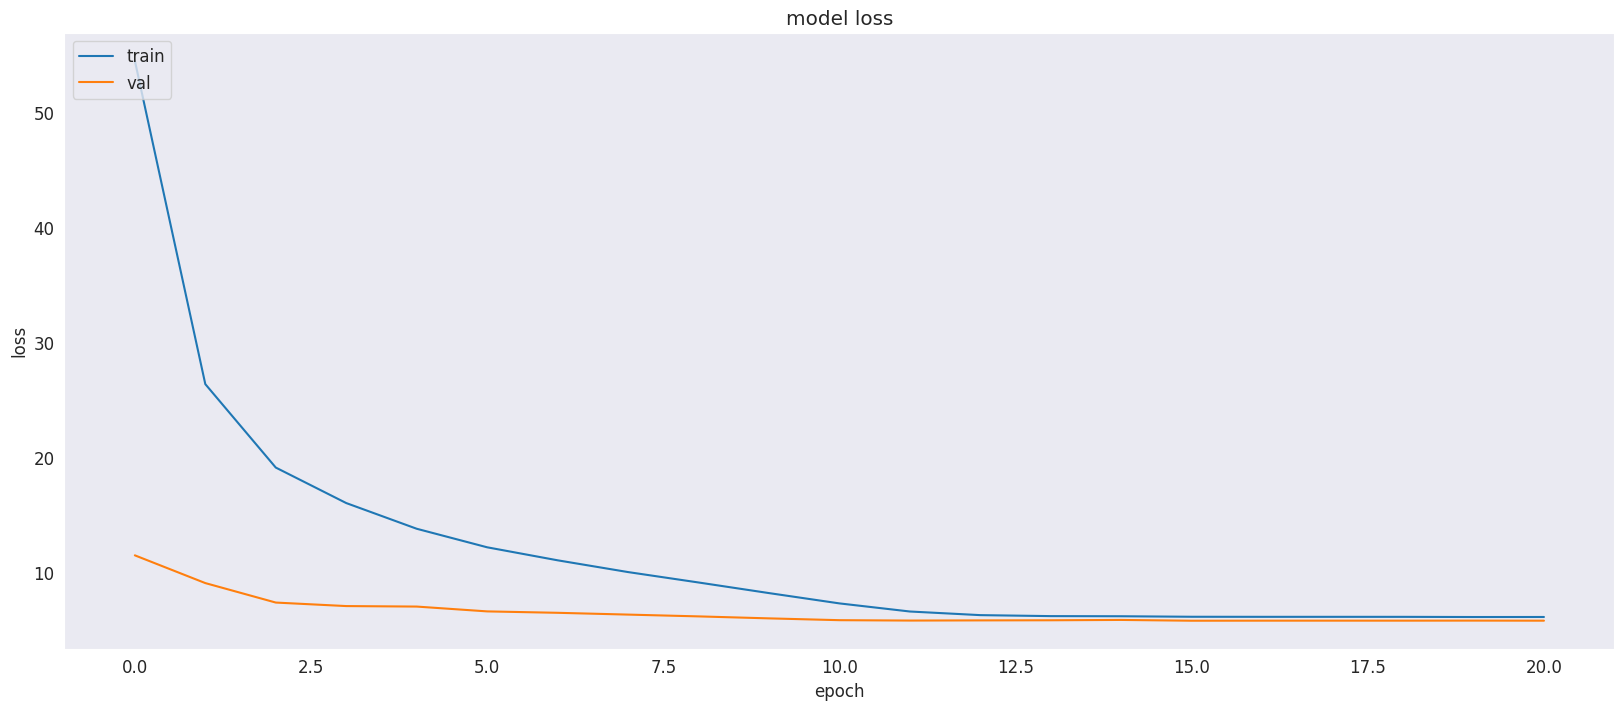

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [ ]:
samples = test
samples.reset_index(drop=True,inplace=True)

In [ ]:
import torch
new_model = torch.load('/content/my_model.h5')


In [ ]:
image_path = '/content/flickr_image/Images'

In [ ]:
import pickle 

with open('saved_features.pkl', 'wb') as f:
    pickle.dump(features, f)
        

NameError: ignored

In [ ]:
test.to_csv(r'/content/test.csv')

In [ ]:
import pickle 
with open('saved_features.pkl', 'rb') as f:
    features = pickle.load(f)


EOFError: ignored

In [ ]:
import pandas as pd
# test = pd.read_csv(r'/content/test.csv')
samples = test
captions_mix = pd.read_csv(r'/content/captionsMeasure.csv')

In [ ]:
import math
value = captions_mix.loc[5543, 'caption_generated']

if math.isnan(value):
    print("The value is nan")
else:
    print("The value is not nan")


The value is nan


In [ ]:
for index in range(5543, len(samples)):
    record = samples.iloc[index]
    value = captions_mix.loc[index, 'caption_generated']
    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(new_model , record['image'], tokenizer, max_length, features)
    captions_mix.loc[index,'caption_generated'] = caption

1/1 [==============================] - 0s 30ms/step


In [ ]:
captions_mix.loc[2000, 'caption_generated']

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              1  3688858505_e8afd1475d.jpg   
2              2  3688858505_e8afd1475d.jpg   
3              3  3688858505_e8afd1475d.jpg   
4              4  3688858505_e8afd1475d.jpg   
...          ...                        ...   
6065        6065   997722733_0cb5439472.jpg   
6066        6066   997722733_0cb5439472.jpg   
6067        6067   997722733_0cb5439472.jpg   
6068        6068   997722733_0cb5439472.jpg   
6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     startseq blond girl in green dress and elabora...   
1     startseq few people with girl standing up in t...   
2              startseq girl is wear green dress endseq   
3     startseq blonde girl wearing green dress stand...   
4     startseq woman in green dress being observed e...   
...                                                 ...   
6065  startseq man in pink shirt climbs rock face en...   
6066  startseq man is rock climbing high in the air ...   
6067  startseq person in red shirt climbing up rock ...   
6068          startseq rock climber in red shirt endseq   
6069  startseq rock climber practices on rock climbi...   

                                      caption_generated  
0     startseq two girls are sitting on the street e...  
1     startseq two girls are sitting on the street e...  
2     startseq two girls are sitting on the street e...  
3     startseq two girls are sitting on the street e...  
4     startseq two girls are sitting on the street e...  
...                                                 ...  
6065                                                NaN  
6066                                                NaN  
6067                                                NaN  
6068                                                NaN  
6069                                                NaN  

[6070 rows x 4 columns]

In [ ]:
captions_mix.to_csv(r'/content/captionsMeasure.csv')
# captions_mix

In [ ]:
from google.colab import files
files.download('/content/captionsMeasure.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
captions_mix

In [ ]:
# captions_mix = pd.merge(captions_mix, samples, left_on='image', right_on='image_name', how='left')
# captions_mix.to_csv(r'/content/captionsMeasureMerged.csv')

KeyError: ignored

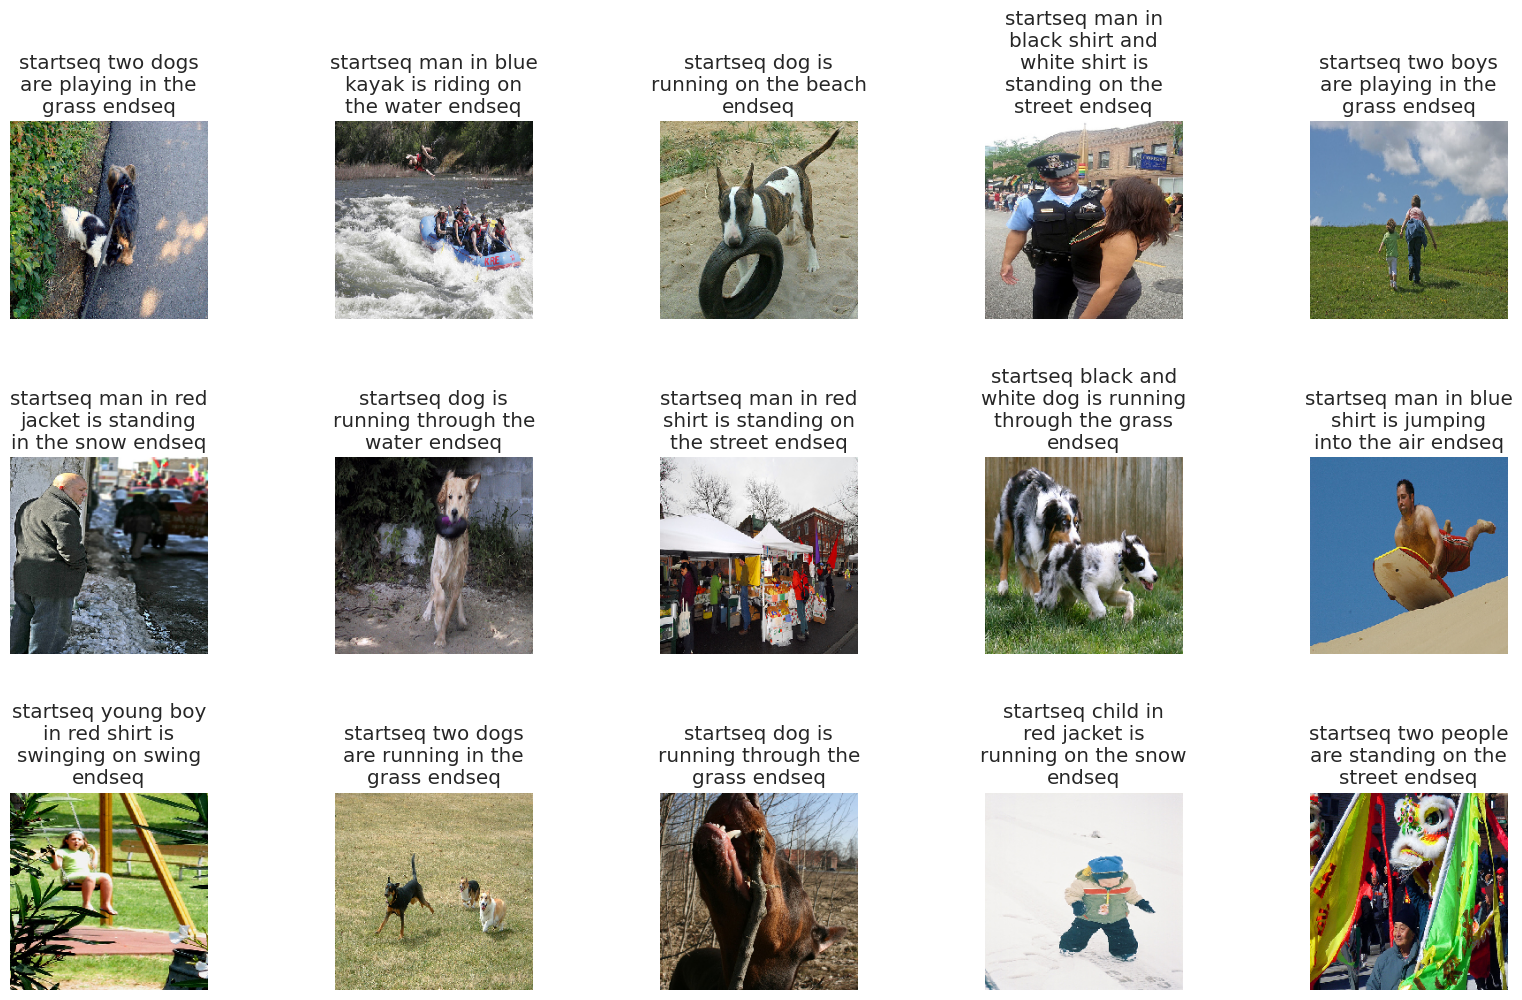

In [ ]:
display_images(samples)

In [ ]:
captions_mix = pd.read_csv(r'/content/captionsMeasure.csv')

In [ ]:
captions_mix

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              1  3688858505_e8afd1475d.jpg   
2              2  3688858505_e8afd1475d.jpg   
3              3  3688858505_e8afd1475d.jpg   
4              4  3688858505_e8afd1475d.jpg   
...          ...                        ...   
6065        6065   997722733_0cb5439472.jpg   
6066        6066   997722733_0cb5439472.jpg   
6067        6067   997722733_0cb5439472.jpg   
6068        6068   997722733_0cb5439472.jpg   
6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     startseq blond girl in green dress and elabora...   
1     startseq few people with girl standing up in t...   
2              startseq girl is wear green dress endseq   
3     startseq blonde girl wearing green dress stand...   
4     startseq woman in green dress being observed e...   
...                                                 ...   
6065  startseq man in pink shirt climbs rock face en...   
6066  startseq man is rock climbing high in the air ...   
6067  startseq person in red shirt climbing up rock ...   
6068          startseq rock climber in red shirt endseq   
6069  startseq rock climber practices on rock climbi...   

                                      caption_generated      euc_dist  \
0     startseq two girls are sitting on the street e...  17401.289062   
1     startseq two girls are sitting on the street e...   8790.574219   
2     startseq two girls are sitting on the street e...   6636.255371   
3     startseq two girls are sitting on the street e...   9649.615234   
4     startseq two girls are sitting on the street e...   6614.353516   
...                                                 ...           ...   
6065                                                NaN           NaN   
6066                                                NaN           NaN   
6067                                                NaN           NaN   
6068                                                NaN           NaN   
6069                                                NaN           NaN   

       cos_sim  
0     0.680801  
1     0.755851  
2     0.841718  
3     0.768175  
4     0.847356  
...        ...  
6065       NaN  
6066       NaN  
6067       NaN  
6068       NaN  
6069       NaN  

[6070 rows x 6 columns]

In [ ]:
import torch

tokenize validate captions vs test captions, eu+cosine

In [ ]:
!pip -q install transformers==4.26.0
# captions_mix = pd.merge(captions, captions_generated, left_on='image', right_on='image_name', how='left')

from transformers import BertTokenizer
tokenizerBert = BertTokenizer.from_pretrained('bert-base-uncased')

captions_mix['euc_dist'] = np.nan
captions_mix['cos_sim'] = np.nan

for idx, row in captions_mix.iterrows():
    encoded_text = tokenizerBert.encode_plus(
                    row['caption'], add_special_tokens = True, truncation = True, 
                    max_length = 64, padding = 'max_length',
                    return_attention_mask = True,
                    return_tensors = 'pt')
    caption_encode = encoded_text['input_ids']

    encoded_text = tokenizerBert.encode_plus(
                    row['caption_generated'], add_special_tokens = True, truncation = True, 
                    max_length = 64, padding = 'max_length',
                    return_attention_mask = True,
                    return_tensors = 'pt')
    generated_caption_encode = encoded_text['input_ids']

    euc_dist = (caption_encode - generated_caption_encode).pow(2).sum().sqrt()

    cos = torch.nn.CosineSimilarity(dim=1)
    cos_similarity = cos(caption_encode.float(), generated_caption_encode.float())

    captions_mix.loc[idx, 'euc_dist'] = euc_dist.item()
    captions_mix.loc[idx, 'cos_sim'] = cos_similarity.item()



ValueError: ignored

In [ ]:
captions_mix.to_csv('/content/captionsMeasure.csv', index=False)

captions_mix.head()

Unnamed: 0                      image  \
0           0  3688858505_e8afd1475d.jpg   
1           1  3688858505_e8afd1475d.jpg   
2           2  3688858505_e8afd1475d.jpg   
3           3  3688858505_e8afd1475d.jpg   
4           4  3688858505_e8afd1475d.jpg   

                                             caption  \
0  startseq blond girl in green dress and elabora...   
1  startseq few people with girl standing up in t...   
2           startseq girl is wear green dress endseq   
3  startseq blonde girl wearing green dress stand...   
4  startseq woman in green dress being observed e...   

                                   caption_generated      euc_dist   cos_sim  
0  startseq two girls are sitting on the street e...  17401.289062  0.680801  
1  startseq two girls are sitting on the street e...   8790.574219  0.755851  
2  startseq two girls are sitting on the street e...   6636.255371  0.841718  
3  startseq two girls are sitting on the street e...   9649.615234  0.768175  
4  startseq two girls are sitting on the street e...   6614.353516  0.847356

In [ ]:
measure_mean = captions_mix[['image', 'euc_dist', 'cos_sim']].groupby(['image']).mean()

measure_mean.agg(['mean'])

euc_dist   cos_sim
mean  16600.379239  0.679691

In [ ]:
euc_min = captions_mix[['image', 'euc_dist']].groupby(['image']).min()
euc_min.agg(['mean'])



euc_dist
mean  9802.976316

In [ ]:
cos_max = captions_mix[['image', 'cos_sim']].groupby(['image']).max()
cos_max.agg(['mean'])

cos_sim
mean  0.819306